# (17) Sim New -- draft

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os, sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from model.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _create_ticks(of, tick_spacing: int = None):
    if tick_spacing is None:
        tick_spacing = 15 // of.res  # of.fov // 3
    of.ticks, of.ticklabels = zip(*[
        (i, str(int(np.round(np.rad2deg(x))))) for i, x
        in enumerate(of.span) if i % tick_spacing == 0
    ])
    return


def show_thetaphi(t, p):
    fig, axes = create_figure(1, 4, (13, 2.5), tight_layout=True)
    im = axes[0].imshow(t, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[0])

    im = axes[2].imshow(p, cmap='hsv', vmin=0, vmax=2*np.pi)
    plt.colorbar(im, ax=axes[2])

    for ax in [axes[0], axes[2]]:
        ax.invert_yaxis()
        ax.tick_params(labelsize=10)
        ax.set(
            xticks=of.ticks,
            yticks=of.ticks,
            xticklabels=of.ticklabels,
            yticklabels=of.ticklabels,
        )

    axes[1].axvline(np.deg2rad(fov), color='r', ls='--', label=f'{fov} deg')
    sns.histplot(
        t.ravel(), ax=axes[1], label=r'$\theta$',
        bins=np.linspace(0, np.pi/2, 91), stat='count')
    sns.histplot(
        p.ravel(), ax=axes[3], label=r'$\phi$', color='C0',
        bins=np.linspace(0, 2*np.pi, 37), stat='count')
    
    sns.histplot(
        p[t <= np.deg2rad(fov)], ax=axes[3], label=r'$\phi$' + f' (<{fov})', color='C1',
        bins=np.linspace(0, 2*np.pi, 37), stat='count')
    for ax in [axes[1], axes[3]]:
        ax.set_ylabel('')
        ax.legend(fontsize=8, loc='upper left')

    plt.show()
    
    
def show_xyzd(x, y, z, d, cmap='Spectral', grid=False):
    fig, axes = create_figure(1, 4, (12, 2.5), 'all', 'all', tight_layout=True)
    im = axes[0].imshow(x, cmap=cmap)
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title(r'$\mathcal{x}$', y=1.02, fontsize=17)

    im = axes[1].imshow(y, cmap=cmap)
    plt.colorbar(im, ax=axes[1])
    axes[1].set_title(r'$\mathcal{y}$', y=1.02, fontsize=17)

    im = axes[2].imshow(z, cmap=cmap)
    plt.colorbar(im, ax=axes[2])
    axes[2].set_title(r'$\mathcal{z}$', y=1.02, fontsize=17)

    im = axes[3].imshow(d, cmap=cmap)
    plt.colorbar(im, ax=axes[3])
    axes[3].set_title(r'$\mathcal{d} = \sqrt{\mathcal{x}^2+\mathcal{y}^2+\mathcal{z}^2}$', y=1.02, fontsize=14)

    axes[-1].invert_yaxis()
    for ax in axes.flat:
        ax.tick_params(labelsize=10)
        ax.set(
            xticks=of.ticks,
            yticks=of.ticks,
            xticklabels=of.ticklabels,
            yticklabels=of.ticklabels,
        )
    if grid:
        add_grid(axes)
    plt.show()
    
    
def hist_xyzd(x, y, d, z=None, bins=30):
    kws = {
        'bins': bins,
        'stat': 'percent',
    }
    fig, axes = create_figure(2, 4, (13, 5), sharey='all', constrained_layout=True)
    sns.histplot(x.ravel(), ax=axes[0, 0], **kws)
    sns.histplot(y.ravel(), ax=axes[0, 1], **kws)
    if z is not None:
        sns.histplot(z.ravel(), ax=axes[0, 2], **kws)
    sns.histplot(d.ravel(), ax=axes[0, 3], **kws)

    sns.histplot(x[theta < np.deg2rad(fov)], ax=axes[1, 0], **kws)
    sns.histplot(y[theta < np.deg2rad(fov)], ax=axes[1, 1], **kws)
    if z is not None:
        sns.histplot(z[theta < np.deg2rad(fov)], ax=axes[1, 2], **kws)
    sns.histplot(d[theta < np.deg2rad(fov)], ax=axes[1, 3], **kws)
    
    axes[0, 0].set_title(r'$x$', y=1.02, fontsize=17)
    axes[0, 1].set_title(r'$y$', y=1.02, fontsize=17)
    axes[0, 2].set_title(r'$z$', y=1.02, fontsize=17)
    axes[0, 3].set_title(r'$d$', y=1.02, fontsize=17)
    
    plt.show()

In [3]:
def _check_input(x, axis):
	if not isinstance(x, np.ndarray):
		x = np.array(x)
	if not x.ndim == 2:
		x = np.expand_dims(x, axis)
	return x

In [4]:
fov = 45
dim = 65
res = 2*fov/(dim-1)
res

1.40625

In [5]:
%%time

self = of = OpticFlow(
    category='fixate',
    num=100000,
    n_obj=3,
    fov=fov,
    res=res,
).compute_coords()
_create_ticks(of)
of.alpha.shape

CPU times: user 2min 42s, sys: 26.7 s, total: 3min 9s
Wall time: 3min 10s


(65, 65, 2)

<AxesSubplot:>

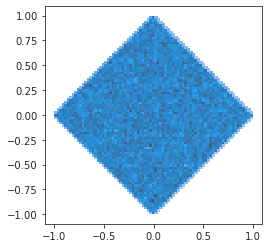

In [6]:
ax = sns.histplot(x=self.fix[:, 0], y=self.fix[:, 1])
ax_square(ax)

In [7]:
self.fix

array([[ 0.27392337, -0.46042657,  1.        ],
       [ 0.21327155,  0.45899312,  1.        ],
       [ 0.08724998,  0.87014485,  1.        ],
       ...,
       [-0.42474934,  0.25277721,  1.        ],
       [ 0.36939448, -0.15105693,  1.        ],
       [-0.6635667 ,  0.17189671,  1.        ]])

In [8]:
%%time

objects, masks = self.add_object()

CPU times: user 2min 30s, sys: 2min 54s, total: 5min 24s
Wall time: 5min 26s


In [9]:
for n, obj in self.objects.items():
    for i in range(2):
        corr = sp_stats.pearsonr(self.fix[:, i], obj.x[:, i] - self.fix[:, i])[0]
        print(f"obj #{n}, i = {i}, corr = {corr:0.3f}")

obj #1, i = 0, corr = -0.001

obj #1, i = 1, corr = 0.006

obj #2, i = 0, corr = -0.003

obj #2, i = 1, corr = -0.003

obj #3, i = 0, corr = 0.005

obj #3, i = 1, corr = 0.001

<AxesSubplot:ylabel='Count'>

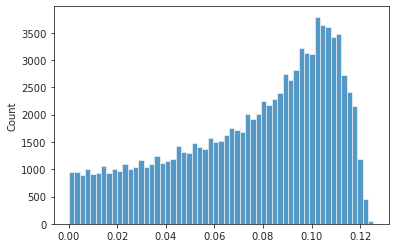

In [13]:
sns.histplot(self.objects[1].size)

In [53]:
100 * (self.objects[1].size < 10 / (self.dim ** 2)).sum() / self.num

0.954

In [54]:
ii = np.argmax(objects[2].size)
ii

76029

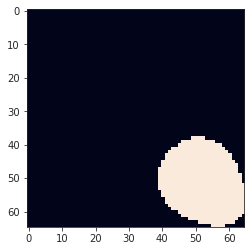

In [55]:
plt.imshow(masks[2][ii])

In [56]:
objects[2].x[ii]

array([0.0178415 , 0.03680254, 0.61019187])

In [57]:
sp_stats.pearsonr(objects[2].size, objects[2].x[:, 2])[0]

-0.3383506925506222

In [58]:
sp_stats.pearsonr(objects[2].size, objects[2].r[:, 0])[0]

-0.7537539337718353

In [59]:
sp_stats.pearsonr(objects[2].size, objects[2].r[:, 1])[0]

-0.31280445263444384

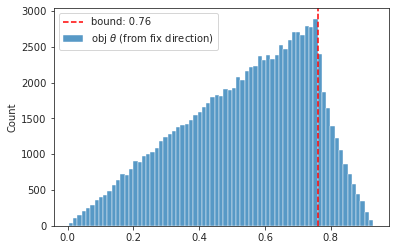

In [65]:
sns.histplot(objects[2].r[:, 1], label='obj ' + r'$\theta$' + ' (from fix direction)')
bound = np.deg2rad(self.obj_bound * self.fov)
plt.axvline(bound, color='r', ls='--', label=f"bound: {bound:0.2f}")
plt.legend()
plt.show()

In [17]:
%%time

df = []
b = 0.97
self.obj_bound = b
for low in tqdm(np.linspace(0.32, 0.34, 21)):
    self.obj_zlim = (low, 1.0)
    pos = self.sample_pos(flat_criterion=True)

    c1 = sp_stats.pearsonr(self.fix[:, 0], pos[:, 0] - self.fix[:, 0])[0]
    c2 = sp_stats.pearsonr(self.fix[:, 1], pos[:, 1] - self.fix[:, 1])[0]
    df.append({
        'b': [np.round(b, 3)] * 3,
        'low': [np.round(low, 4)] * 3,
        'score': [c1, c2, (c1 + c2) / 2],
        'label': ['c1', 'c2', 'c'],
    })
df = pd.DataFrame(merge_dicts(df))

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 11min 12s, sys: 6.42 s, total: 11min 19s
Wall time: 9min 57s


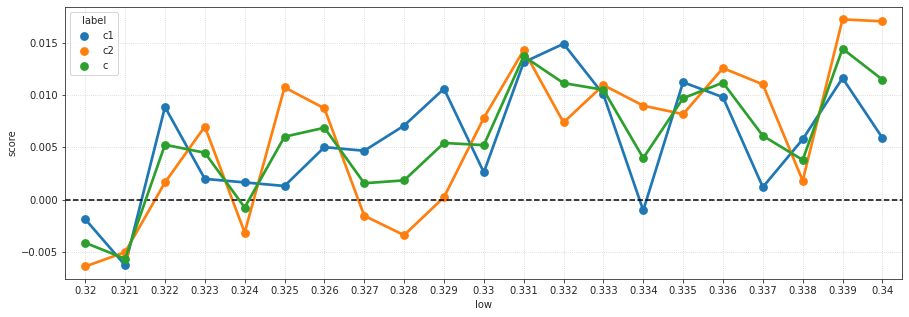

In [18]:
fig, ax = create_figure(figsize=(15, 5))
sns.pointplot(data=df, x='low', y='score', hue='label', ax=ax)
ax.axhline(0, color='k', ls='--')
ax.grid();

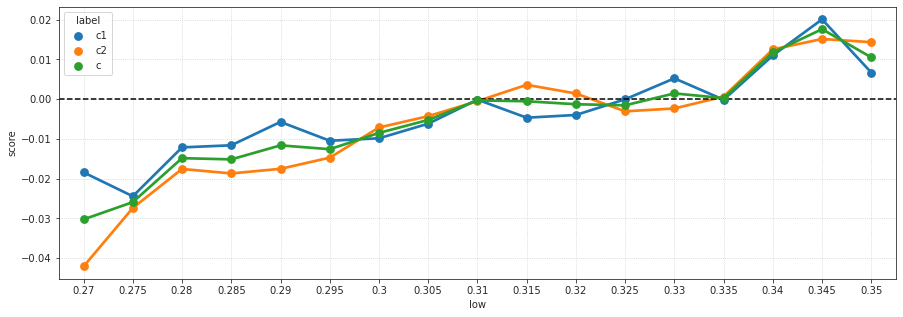

In [22]:
%%time

df = []
for b in (np.linspace(0.90, 1.0, 11)):
    self.obj_bound = b
    for low in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        self.obj_zlim = (low, 1.0)
        pos = self.sample_pos(flat_criterion=True)
        
        c1 = sp_stats.pearsonr(self.fix[:, 0], pos[:, 0] - self.fix[:, 0])[0]
        c2 = sp_stats.pearsonr(self.fix[:, 1], pos[:, 1] - self.fix[:, 1])[0]
        df.append({
            'b': [np.round(b, 3)] * 3,
            'low': [low] * 3,
            'score': [c1, c2, (c1 + c2) / 2],
            'label': ['c1', 'c2', 'c'],
        })
df = pd.DataFrame(merge_dicts(df))

CPU times: user 36min 15s, sys: 52.6 s, total: 37min 7s
Wall time: 30min 7s


In [23]:
df

,b,low,score,label
0,0.9,0.20,-0.139534,c1
1,0.9,0.20,-0.139189,c2
2,0.9,0.20,-0.139361,c
3,0.9,0.25,-0.112699,c1
4,0.9,0.25,-0.116777,c2
...,...,...,...,...
226,1.0,0.45,0.081246,c2
227,1.0,0.45,0.082842,c
228,1.0,0.50,0.104360,c1
229,1.0,0.50,0.097155,c2


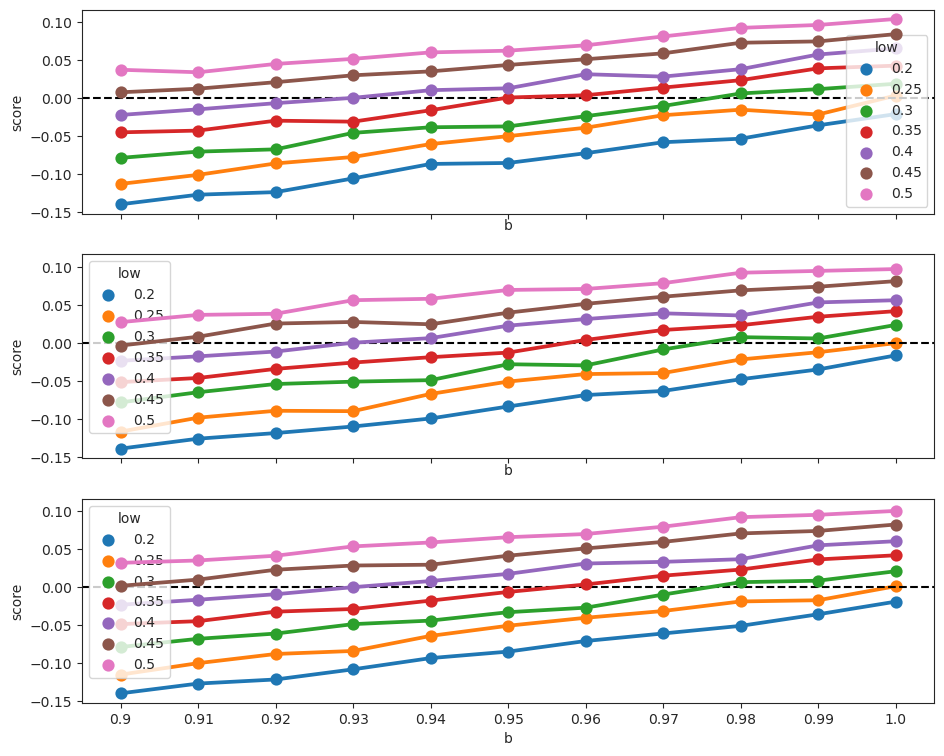

In [39]:
fig, axes = create_figure(3, 1, (11, 9), 'all', 'all')
sns.pointplot(data=df.loc[df['label'] == 'c1'], x='b', y='score', hue='low', ax=axes[0])
sns.pointplot(data=df.loc[df['label'] == 'c2'], x='b', y='score', hue='low', ax=axes[1])
sns.pointplot(data=df.loc[df['label'] == 'c'], x='b', y='score', hue='low', ax=axes[2])
for ax in axes.flat:
    ax.axhline(0, color='k', ls='--')

In [50]:
c1 = df.loc[df['label'] == 'c1', 'score'].to_numpy()
c2 = df.loc[df['label'] == 'c2', 'score'].to_numpy()
c = df.loc[df['label'] == 'c', 'score'].to_numpy()
len(c1), len(c2), len(c)

(77, 77, 77)

In [58]:
ids = np.argsort(np.abs(c1) + np.abs(c2))
ids

array([25, 71, 45,  5, 38, 58, 32, 65, 18, 51, 12, 52, 11, 64, 31, 39, 57,
       70, 72,  4, 19, 59, 44, 24, 26, 33, 50, 46, 17,  6, 37, 53, 63, 13,
       66, 60, 43, 20, 40, 73, 30, 10,  3, 23, 36, 56, 47, 27, 67, 34, 54,
       49, 16, 74, 29, 41,  9, 48, 42, 61, 68,  2, 55, 75, 22, 35, 15, 62,
       28, 69,  8, 76, 21,  1, 14,  7,  0])

In [66]:
i = 2
c1[ids[i]], c2[ids[i]], c[ids[i]]

(0.00400348004558955, 0.003845782199841332, 0.003924631122715441)

In [67]:
_df = df.loc[df['label'] == 'c']
_df

,b,low,score,label
2,0.9,0.20,-0.139361,c
5,0.9,0.25,-0.114738,c
8,0.9,0.30,-0.078387,c
11,0.9,0.35,-0.048249,c
14,0.9,0.40,-0.022765,c
...,...,...,...,...
218,1.0,0.30,0.021335,c
221,1.0,0.35,0.042337,c
224,1.0,0.40,0.060866,c
227,1.0,0.45,0.082842,c


In [68]:
_df.iloc[ids[i]]

b            0.96
low          0.35
score    0.003925
label           c
Name: 137, dtype: object

In [70]:
b = _df.iloc[ids[i]]['b']
low = _df.iloc[ids[i]]['low']

b, low

(0.96, 0.35)

In [71]:
self.obj_bound = b
self.obj_zlim = (low, 1.0)
pos = self.sample_pos(flat_criterion=True)

In [72]:
corr_0 = sp_stats.pearsonr(self.fix[:, 0], pos[:, 0] - self.fix[:, 0])[0]
corr_1 = sp_stats.pearsonr(self.fix[:, 1], pos[:, 1] - self.fix[:, 1])[0]

corr_0, corr_1

(0.009418866162505932, 0.009357660393935204)

<AxesSubplot:>

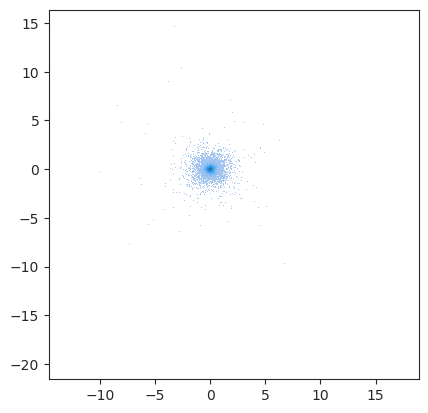

In [78]:
ax = sns.histplot(x=pos[:, 0], y=pos[:, 1])
ax_square(ax)

<AxesSubplot:ylabel='Count'>

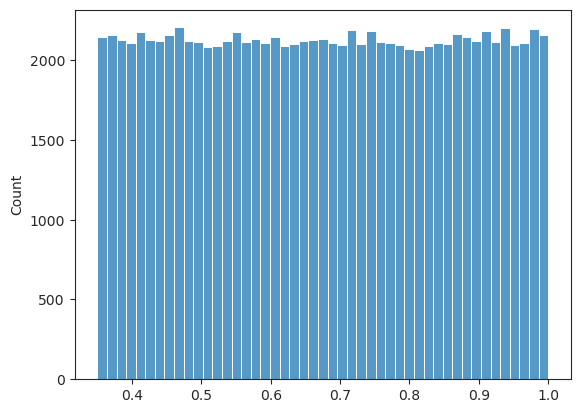

In [79]:
sns.histplot(pos[:, 2])

In [16]:
corr_0 = {}
corr_1 = {}
corr_mean = {}
for b in tqdm(np.linspace(0.90, 1.0, 51)):
    self.obj_bound = b
    pos = self.sample_pos(flat_criterion=True)
    
    key = np.round(b, 3)
    corr_0[key] = sp_stats.pearsonr(self.fix[:, 0], pos[:, 0] - self.fix[:, 0])[0]
    corr_1[key] = sp_stats.pearsonr(self.fix[:, 1], pos[:, 1] - self.fix[:, 1])[0]
    corr_mean[key] = (corr_0[key] + corr_1[key]) / 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [17]:
corr_mean

{0.9: 0.032103428728071134,
 0.902: 0.0309979522790314,
 0.904: 0.02417909988064579,
 0.906: 0.03453147752730761,
 0.908: 0.03589776531741826,
 0.91: 0.03267517686694758,
 0.912: 0.038481059480201515,
 0.914: 0.03283466194770131,
 0.916: 0.03954838000590188,
 0.918: 0.03780506159724261,
 0.92: 0.046035917128356016,
 0.922: 0.043482123785500565,
 0.924: 0.05173901283795537,
 0.926: 0.047242364038647934,
 0.928: 0.04797853573154501,
 0.93: 0.05523104824026524,
 0.932: 0.05034615492334295,
 0.934: 0.06020324034978884,
 0.936: 0.05441861598677055,
 0.938: 0.059865727290106495,
 0.94: 0.05481941050004144,
 0.942: 0.06352604322168348,
 0.944: 0.05977078152988419,
 0.946: 0.0623630143797001,
 0.948: 0.0628523026886906,
 0.95: 0.06293866612450966,
 0.952: 0.06608933476829587,
 0.954: 0.07003805627537181,
 0.956: 0.06592826510214035,
 0.958: 0.07522143640369051,
 0.96: 0.07480810347882215,
 0.962: 0.07789008925344146,
 0.964: 0.07343045730281372,
 0.966: 0.08149573921471871,
 0.968: 0.079871593

CPU times: user 2min 35s, sys: 2min 35s, total: 5min 10s
Wall time: 5min 12s


In [10]:
len(objects), len(masks)

(3, 3)

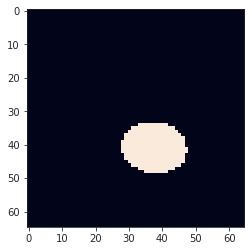

In [13]:
plt.imshow(masks[3][23])

<AxesSubplot:ylabel='Count'>

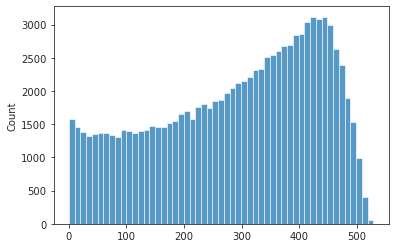

In [14]:
sns.histplot(masks[3].sum(1).sum(1))

In [19]:
100 * len(np.where(masks[3].sum(1).sum(1) < 20)[0]) / len(masks[3])

3.044

In [27]:
corr = {}
for i in range(2):
    corr[i] = sp_stats.pearsonr(self.fix[:, i], objects[3].x[:, i] - self.fix[:, i])[0]
corr

{0: 0.1025516080083367, 1: 0.0956148337039043}

<AxesSubplot:ylabel='Count'>

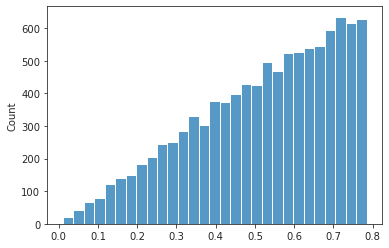

In [45]:
sns.histplot(obj.r[:, 1])

In [47]:
sp_stats.pearsonr(obj.r[:, 1], obj.size)

(-0.28221001294578396, 1.8609820177361352e-182)

In [48]:
sp_stats.pearsonr(obj.r[:, 0], obj.size)

(-0.7599674868738969, 0.0)

In [49]:
sp_stats.pearsonr(obj.r[:, 2], obj.size)

(0.018495034225243137, 0.06439568983286607)

In [186]:
np.tan(np.deg2rad(self.obj_bound * self.fov))

0.8816185923631891

In [187]:
def sample_pos(self):
    bound = np.tan(np.deg2rad(
        self.obj_bound * self.fov))
    pos = np_nans((self.num, 3))
    for i in range(self.num):
        while True:
            u = self.rng.normal(size=3)
            _, th, ph = cart2polar(
                self.R[i].T @ u).ravel()
            a = np.tan(th) * np.cos(ph)
            b = np.tan(th) * np.sin(ph)
            cond = (
                np.abs(a) < bound and
                np.abs(b) < bound
            )
            if cond:
                break
        _, th, ph = cart2polar(u).ravel()
        z = self.rng.uniform(
            low=self.obj_zlim[0],
            high=self.obj_zlim[1],
        )
        pos[i] = polar2cart(np.array(
            [z / np.cos(th), th, ph]
        )).ravel()
    assert not np.isnan(pos).sum()
    return pos

In [188]:
pos = sample_pos(of)
pos.shape

(10000, 3)

In [198]:
corr_0 = {}
corr_1 = {}
corr_mean = {}
for b in tqdm(np.linspace(0.90, 1.0, 11)):
    self.obj_bound = b
    pos = sample_pos(of)
    key = np.round(b, 2)
    corr_0[key] = sp_stats.pearsonr(self.fix[:, 0], pos[:, 0] - self.fix[:, 0])[0]
    corr_1[key] = sp_stats.pearsonr(self.fix[:, 1], pos[:, 1] - self.fix[:, 1])[0]
    corr_mean[key] = (corr_0[key] + corr_1[key]) / 2

  0%|          | 0/11 [00:00<?, ?it/s]

In [199]:
corr_mean

{0.9: 0.031335795447818955,
 0.91: 0.03689039087469242,
 0.92: 0.04703906679880819,
 0.93: 0.05992518405761382,
 0.94: 0.05738874836240364,
 0.95: 0.04720127629066212,
 0.96: 0.08857040830088293,
 0.97: 0.08737004555844469,
 0.98: 0.06071880456862307,
 0.99: 0.09002540982200719,
 1.0: 0.10436621138034238}

In [110]:
obj_pos_in_self = 'aij, ai -> aj'
obj_pos_in_self = np.einsum(obj_pos_in_self, self.R, pos)
obj_pos_alpha = np.stack([
    np.arctan2(obj_pos_in_self[:, 0], obj_pos_in_self[:, 2]),
    np.arctan2(obj_pos_in_self[:, 1], obj_pos_in_self[:, 2]),
], axis=1)
obj_pos_alpha.shape

(10000, 2)

<AxesSubplot:>

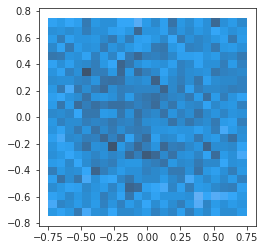

In [111]:
ax = sns.histplot(x=obj_pos_alpha[:, 0], y=obj_pos_alpha[:, 1])
ax_square(ax)

In [112]:
np.rad2deg(obj_pos_alpha.min()), np.rad2deg(obj_pos_alpha.max())

(-42.74705375955756, 42.742071407394995)

In [86]:
sp_stats.pearsonr(self.fix[:, 0], obj_pos_alpha[:, 0])

(0.0034426326959360824, 0.7306798994096924)

In [88]:
sp_stats.pearsonr(self.fix[:, 1], obj_pos_alpha[:, 1])

(0.015075734487387703, 0.13169006111097686)

In [89]:
sp_stats.pearsonr(self.fix[:, 0], obj.alpha[:, 0])

(0.006612761866878859, 0.5084835797707775)

In [90]:
sp_stats.pearsonr(self.fix[:, 0], obj.alpha[:, 1])

(0.001301066278454708, 0.896494890528236)

<AxesSubplot:ylabel='Count'>

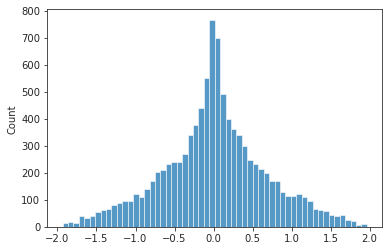

In [42]:
sns.histplot(obj.v[:, 2])

<AxesSubplot:ylabel='Count'>

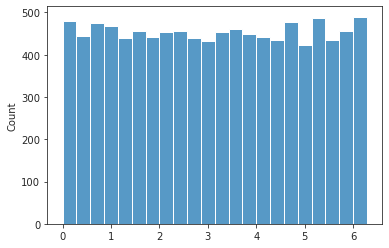

In [45]:
sns.histplot(cart2polar(obj.v)[:, 2])

<AxesSubplot:>

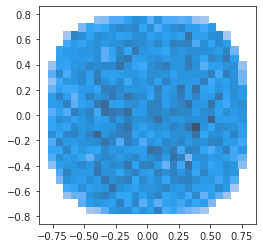

In [36]:
ax = sns.histplot(x=obj.alpha[:, 0], y=obj.alpha[:, 1])
ax_square(ax)

<AxesSubplot:ylabel='Count'>

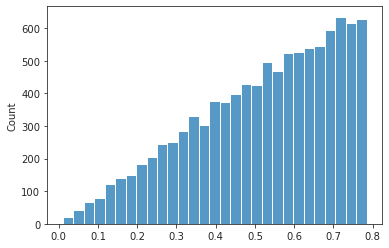

In [32]:
sns.histplot(obj.r[:, 1])

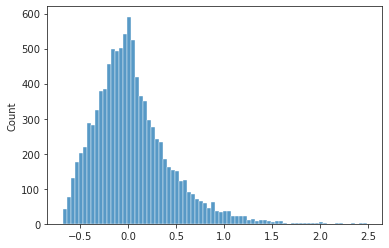

In [29]:
sns.histplot(np.log(obj.r[:, 0]));

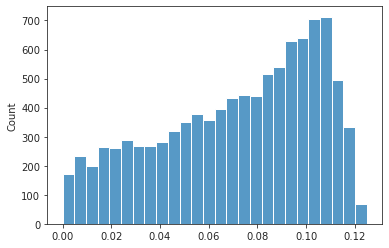

In [23]:
sns.histplot(obj.size);

In [28]:
sp_stats.pearsonr(obj.r[:, 0], obj.size)

(-0.7599674868738969, 0.0)

In [8]:
%%time

pos = self.sample_pos()
pos.shape

CPU times: user 3.96 s, sys: 154 ms, total: 4.11 s
Wall time: 3.93 s


(10000, 3)

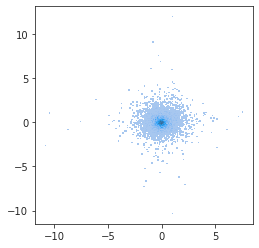

In [9]:
ax = sns.histplot(x=pos[:, 0], y=pos[:, 1])
ax_square(ax);

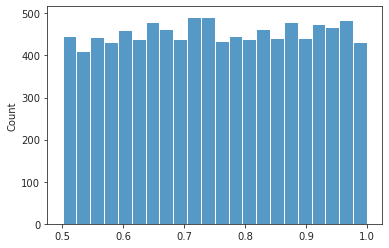

In [10]:
sns.histplot(pos[:, -1]);

In [11]:
i, _ = np.unravel_index(np.argmax(np.abs(pos)), pos.shape)
i

9499

In [12]:
pos[i], self.fix[i]

(array([ 0.97546293, 11.97513069,  0.90222148]),
 array([0.04904823, 0.90654375, 1.        ]))

In [13]:
np.rad2deg(np.arccos(1 - sp_dist.cosine(pos[i], self.fix[i])))

43.490903608743004

44.99677177392378

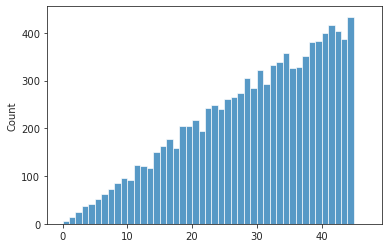

In [14]:
theta_fix_self = []
for i in range(self.num):
    c = sp_dist.cosine(self.fix[i], pos[i])
    c = np.rad2deg(np.arccos(1 - c))
    theta_fix_self.append(c)
sns.histplot(theta_fix_self, bins=np.linspace(0, 47, 48));
np.max(theta_fix_self)

In [15]:
aaaa = sp_stats.pearsonr(self.fix[:, 0], pos[:, 0])[0]
aaaaa = sp_stats.pearsonr(self.fix[:, 0], pos[:, 0] - self.fix[:, 0])[0]
aaaa, aaaaa

(0.5972166519511733, 0.05504588217483551)

In [16]:
aaaa = sp_stats.pearsonr(self.fix[:, 1], pos[:, 1])[0]
aaaaa = sp_stats.pearsonr(self.fix[:, 1], pos[:, 1] - self.fix[:, 1])[0]
aaaa, aaaaa

(0.5812098385055346, 0.03418785332323282)

In [17]:
obj_pos_in_self = 'aij, ai -> aj'
obj_pos_in_self = np.einsum(obj_pos_in_self, self.R, pos)
obj_pos_alpha = np.stack([
    np.arctan2(obj_pos_in_self[:, 0], obj_pos_in_self[:, 2]),
    np.arctan2(obj_pos_in_self[:, 1], obj_pos_in_self[:, 2]),
], axis=1)
obj_pos_alpha.shape

(10000, 2)

In [18]:
sp_stats.pearsonr(obj_pos_alpha[:, 0], pos[:, 0]), sp_stats.pearsonr(obj_pos_alpha[:, 1], pos[:, 1])

((0.674508453941942, 0.0), (0.6618125141640763, 0.0))

In [19]:
sp_stats.pearsonr(obj_pos_alpha[:, 0], self.fix[:, 0]), sp_stats.pearsonr(obj_pos_alpha[:, 1], self.fix[:, 1])

((0.006612761866878859, 0.5084835797707775),
 (-0.019864191277263726, 0.046992612112203354))

In [20]:
sp_stats.pearsonr(obj_pos_alpha[:, 0], self.fix[:, 0] - pos[:, 0]), sp_stats.pearsonr(obj_pos_alpha[:, 1], self.fix[:, 1] - pos[:, 1])

((-0.8351218188148904, 0.0), (-0.8263083750238429, 0.0))

In [21]:
sp_stats.pearsonr(obj_pos_in_self[:, 0], pos[:, 0]), sp_stats.pearsonr(obj_pos_in_self[:, 1], pos[:, 1])

((0.8987965231807686, 0.0), (0.8976352834947073, 0.0))

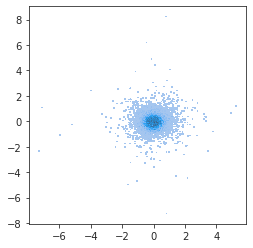

In [22]:
ax = sns.histplot(x=obj_pos_in_self[:, 0], y=obj_pos_in_self[:, 1])
ax_square(ax);

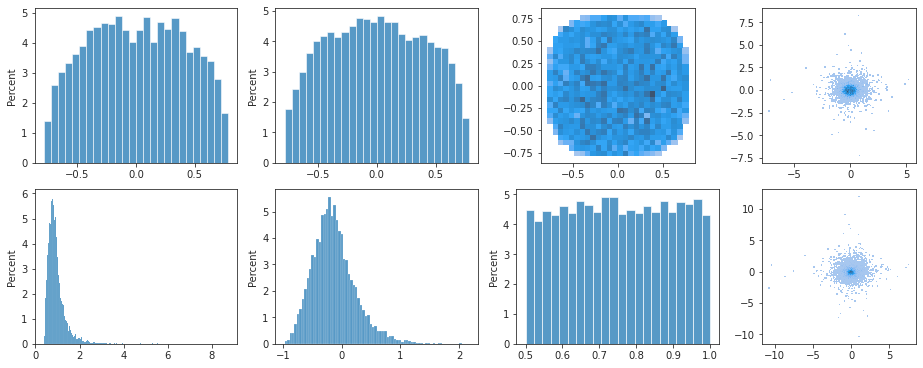

In [23]:
fig, axes = create_figure(2, 4, (13, 5), constrained_layout=True)
sns.histplot(obj_pos_alpha[:, 0], stat='percent', ax=axes[0, 0])
sns.histplot(obj_pos_alpha[:, 1], stat='percent', ax=axes[0, 1])
sns.histplot(x=obj_pos_alpha[:, 0], y=obj_pos_alpha[:, 1], ax=axes[0, 2])
sns.histplot(x=obj_pos_in_self[:, 0], y=obj_pos_in_self[:, 1], ax=axes[0, 3])
ax_square(axes[0, 2:])
sns.histplot(obj_pos_in_self[:, 2], stat='percent', ax=axes[1, 0])
sns.histplot(np.log(obj_pos_in_self[:, 2]), stat='percent', ax=axes[1, 1])
sns.histplot(pos[:, 2], stat='percent', ax=axes[1, 2])
sns.histplot(x=pos[:, 0], y=pos[:, 1], ax=axes[1, 3])
ax_square(axes[1, 3])
plt.show()

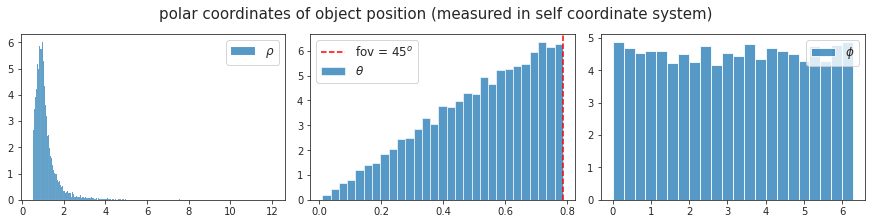

In [24]:
obj_pos_in_self_polar = cart2polar(obj_pos_in_self)
fig, axes = create_figure(1, 3, (12, 3), constrained_layout=True)
for i, lbl in enumerate([r'$\rho$', r'$\theta$', r'$\phi$']):
    ax = axes[i]
    sns.histplot(obj_pos_in_self_polar[:, i], label=lbl, stat='percent', ax=ax)
    if i == 1:
        ax.axvline(
            np.deg2rad(self.fov),
            color='r',
            ls='--',
            label=f"fov = {fov}" + r"$^o$",
        )
    ax.set_ylabel('')
    ax.legend(fontsize=12)
fig.suptitle("polar coordinates of object position (measured in self coordinate system)", fontsize=15)
plt.show()

In [25]:
v = self.sample_vel(self.slf_vlim[0], self.slf_vlim[1])

<AxesSubplot:ylabel='Count'>

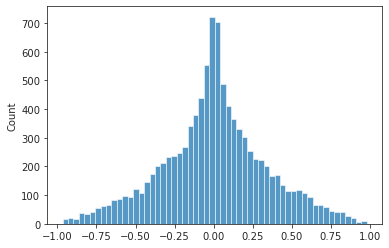

In [26]:
sns.histplot(v[:, 2])

<AxesSubplot:ylabel='Count'>

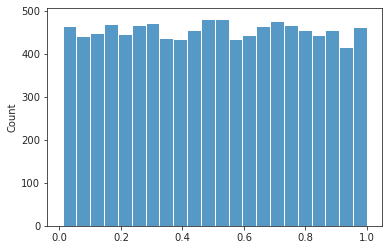

In [27]:
sns.histplot(cart2polar(v)[:, 0])

<AxesSubplot:ylabel='Count'>

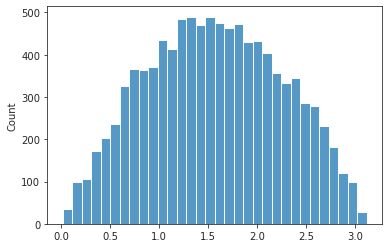

In [28]:
sns.histplot(cart2polar(v)[:, 1])

In [17]:
_Obj = collections.namedtuple(
	typename='Object',
	field_names=[
		'x', 'v',      # coordinate system: real
		'alpha', 'd',  # coordinate system: self
		'size'],
)


In [20]:
obj = _Obj(x=2,v=2, alpha=45,d=2332, size=15)

In [22]:
obj.x

2

In [29]:
self.fix.shape, pos.shape

((10000, 3), (10000, 3))

In [30]:
self.x.shape

(10000, 65, 65, 3)

In [31]:
v_tr = 'aij, ai -> aj'
v_tr = np.einsum(v_tr, self.R, v)
v_tr.shape

(10000, 3)

In [132]:
_Obj = collections.namedtuple(
	typename='Object',
	field_names=[
		'x', 'v',      # real coordinate system
		'alpha', 'd',  # self coordinate system
		'size'],
)

In [32]:
mask = self.x_bg - pos.reshape((-1, 1, 1, 3))
mask = sp_lin.norm(mask[..., :2], axis=-1) < self.obj_r
mask.shape

(10000, 65, 65)

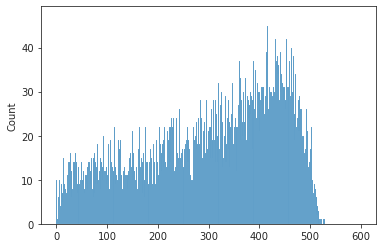

In [33]:
obj_mask_sizes = mask.sum(1).sum(1)
sns.histplot(obj_mask_sizes, bins=np.linspace(0, 600, 601) - 0.5);

In [34]:
np.where(obj_mask_sizes > 520)[0]

array([  29, 4848, 5390, 5703, 9012])

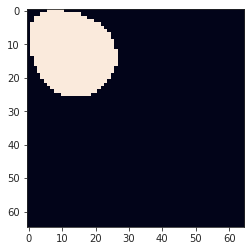

In [35]:
plt.imshow(mask[9012])

In [37]:
100 * (obj_mask_sizes < 20).sum() / len(obj_mask_sizes)

1.66

In [38]:
np.where(obj_mask_sizes == 20)[0]

array([1769, 2247, 2507, 4017, 7040, 9386, 9454])

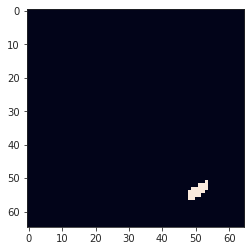

In [39]:
plt.imshow(mask[2507])

In [40]:
sp_stats.pearsonr(obj_mask_sizes, obj_pos_in_self[:, 2])

(-0.7642843972014941, 0.0)

In [41]:
sp_stats.pearsonr(obj_mask_sizes, obj_pos_in_self_polar[:, 0])

(-0.7599674868738969, 0.0)

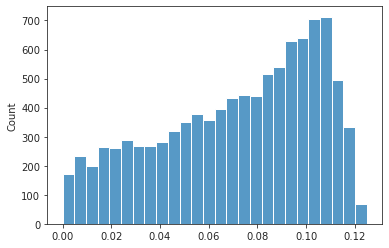

In [42]:
obj_sizes= mask.mean(-1).mean(-1)
sns.histplot(obj_sizes);

In [111]:
x_obj = self.x_bg.copy()
for i in range(self.num):
    x_obj[i, ..., -1][np.where(mask[i])] = pos[i, 2]
x_obj_in_self = 'aij, axyi -> axyj'
x_obj_in_self = np.einsum(x_obj_in_self, self.R, x_obj)

In [112]:
x_obj.shape, x_obj_in_self.shape

((10000, 65, 65, 3), (10000, 65, 65, 3))

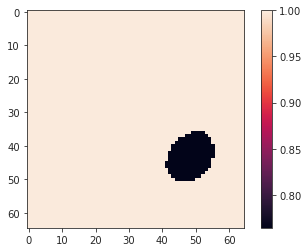

In [113]:
plt.imshow(x_obj[i, ..., 2])
plt.colorbar()

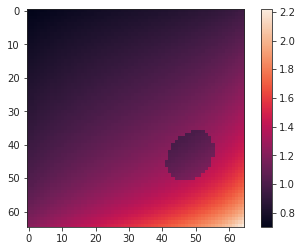

In [115]:
plt.imshow(x_obj_in_self[i, ..., 2])
plt.colorbar();

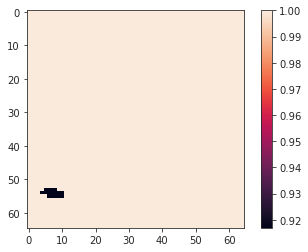

In [124]:
plt.imshow(x_obj[2, ..., 2])
plt.colorbar();

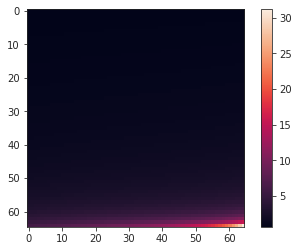

In [125]:
plt.imshow(x_obj_in_self[2, ..., 2])
plt.colorbar();

In [126]:
pos[2, -1]

0.9169604313906327

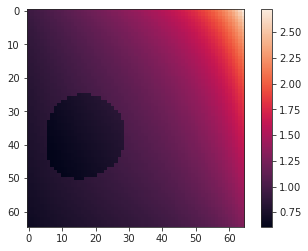

In [127]:
plt.imshow(x_obj_in_self[8, ..., 2])
plt.colorbar();

In [129]:
pos[8, -1]

0.7800077743275576

In [130]:
self.fix[8]

array([ 0.37689346, -0.22215715,  1.        ])

In [107]:
np.min(pos[:, 2]), np.max(pos[:, 2])

(0.5000863387028758, 0.9999764637072064)

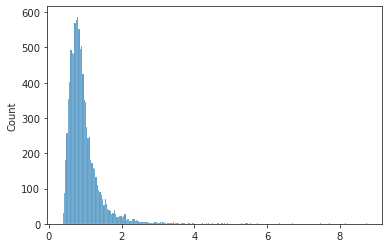

In [108]:
sns.histplot(obj_pos_in_self[:, 2]);

In [109]:
np.min(obj_pos_in_self[:, 2]), np.max(obj_pos_in_self[:, 2])

(0.37964047606462725, 8.74107805359318)

In [73]:
sp_stats.pearsonr(pos_in_self[:, 0], pos_in_self[:, 2])

(-0.012840429653229105, 9.668958058498566e-38)

In [74]:
sp_stats.pearsonr(pos_in_self[:, 1], pos_in_self[:, 2])

(-0.007673315482964398, 1.6747150501504916e-14)

In [75]:
a = np.arctan2(pos_in_self[:, 0], pos_in_self[:, 2])
b = np.arctan2(pos_in_self[:, 1], pos_in_self[:, 2])

In [80]:
i = 2
self.fix[i], pos[i]

(array([0.08724998, 0.87014485, 1.        ]),
 array([ 0.12289235, -0.0095606 ,  0.5510369 ]))

In [81]:
a[i], b[i]

(0.2050275555806474, -0.7277857300802614)

In [82]:
pos_in_self[i]

array([ 0.08663339, -0.37117152,  0.41660768])

In [85]:
sp_stats.pearsonr(self.fix[:, 0], a), sp_stats.pearsonr(self.fix[:, 0], b)

((-0.0006744751738480468, 0.5000097506079018),
 (0.0006340635468094841, 0.5260398264574951))

In [86]:
sp_stats.pearsonr(self.fix[:, 1], a), sp_stats.pearsonr(self.fix[:, 1], b)

((0.0007469376691536459, 0.4551016866685297),
 (-0.0003078812999421663, 0.7581729420142971))

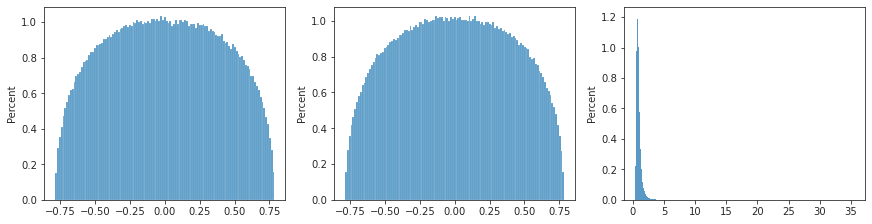

In [93]:
fig, axes = create_figure(1, 3, (12, 3), constrained_layout=True)
sns.histplot(a, stat='percent', ax=axes[0])
sns.histplot(b, stat='percent', ax=axes[1])
sns.histplot(pos_in_self[:, 2], stat='percent', ax=axes[2])
plt.show()

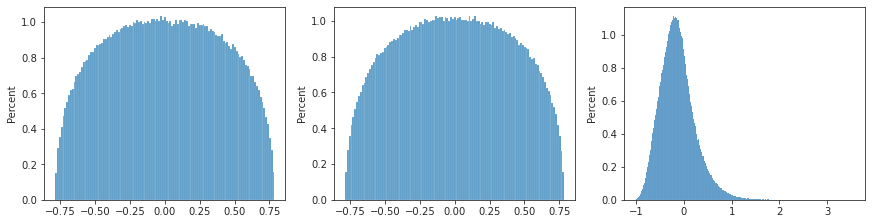

In [94]:
fig, axes = create_figure(1, 3, (12, 3), constrained_layout=True)
sns.histplot(a, stat='percent', ax=axes[0])
sns.histplot(b, stat='percent', ax=axes[1])
sns.histplot(np.log(pos_in_self[:, 2]), stat='percent', ax=axes[2])
plt.show()

In [38]:
def sample_pos(self):
    bound = np.tan(np.deg2rad(
        self.obj_bound_ratio * self.fov))
    print(bound)
    pos = np_nans((self.num, 3))
    for i in range(self.num):
        while True:
            u = self.rng.normal(size=3)
            _, th, ph = cart2polar(
                self.R[i].T @ u).ravel()
            a = np.tan(th) * np.cos(ph)
            b = np.tan(th) * np.sin(ph)
            cond = (
                np.abs(a) < bound and
                np.abs(b) < bound
            )
            if cond:
                break
        _, th, ph = cart2polar(u).ravel()
        z = self.rng.uniform(
            low=self.obj_zlim[0],
            high=self.obj_zlim[1],
        )
        pos[i] = polar2cart(np.array(
            [z/np.cos(th), th, ph]
        )).ravel()
    assert not np.isnan(pos).sum()
    return pos

In [39]:
pos2 = sample_pos(self)

0.924390491658207

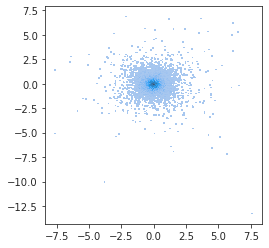

In [45]:
ax = sns.histplot(x=pos2[:, 0], y=pos2[:, 1])
ax_square(ax);

In [40]:
aaaa = sp_stats.pearsonr(self.fix[:, 0], pos2[:, 0])[0]
aaaaa = sp_stats.pearsonr(self.fix[:, 0], pos2[:, 0] - self.fix[:, 0])[0]
aaaa, aaaaa

(0.5779249023383235, 0.0794944196773406)

In [41]:
aaaa = sp_stats.pearsonr(self.fix[:, 1], pos2[:, 1])[0]
aaaaa = sp_stats.pearsonr(self.fix[:, 1], pos2[:, 1] - self.fix[:, 1])[0]
aaaa, aaaaa

(0.5748989107374982, 0.08284625200144084)

In [42]:
pos_in_self = np_nans((self.num, 3))
for i in range(self.num):
    pos_in_self[i] = self.R[i].T @ pos2[i]

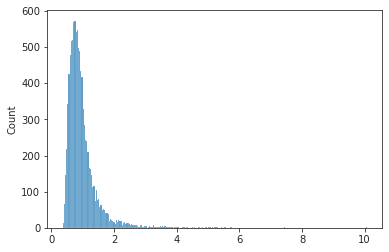

In [43]:
sns.histplot(pos_in_self[:, -1]);

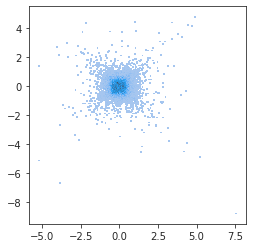

In [44]:
ax = sns.histplot(x=pos_in_self[:, 0], y=pos_in_self[:, 1])
ax_square(ax);

In [34]:
c = sp_dist.cosine(self.fix[i], u)
c = np.arccos(1 - c)
c

1.4024295966861353

## another approach to sample fix

In [41]:
def sample_fix_2(self):
    fix = np_nans((self.num, 3))
    for i in range(self.num):
        while True:
            e = self.rng.normal(size=3)
            c = sp_dist.cosine((0, 0, 1), e)
            c = np.rad2deg(np.arccos(1 - c))
            if c < self.fov:
                break
        _, th, ph = cart2polar(e).ravel()
        fix[i] = polar2cart(np.array(
            [self.z_bg/np.cos(th), th, ph]
        )).ravel()
    assert not np.isnan(fix).sum()
    return fix

In [42]:
fix_2 = sample_fix_2(self)

<AxesSubplot:>

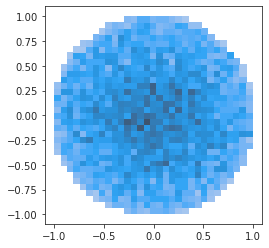

In [44]:
ax = sns.histplot(x=fix_2[:, 0], y=fix_2[:, 1])
ax_square(ax)

In [45]:
self.fix = fix_2

In [46]:
%%time

pos = self.sample_pos()
pos.shape

CPU times: user 4.71 s, sys: 58.2 ms, total: 4.77 s
Wall time: 4.69 s


(10000, 3)

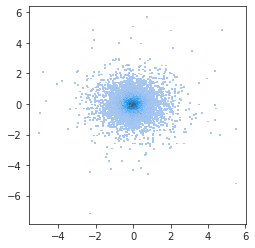

In [47]:
ax = sns.histplot(x=pos[:, 0], y=pos[:, 1])
ax_square(ax);

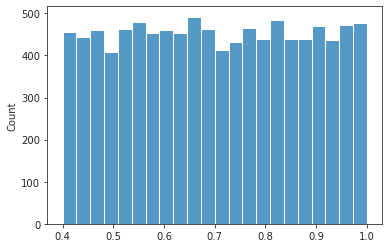

In [48]:
sns.histplot(pos[:, -1]);

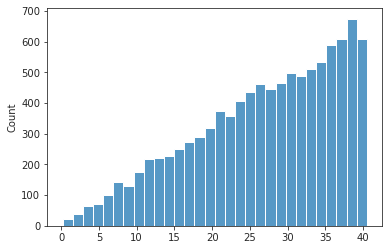

In [49]:
theta_fix_self = []
for i in range(self.num):
    c = sp_dist.cosine(self.fix[i], pos[i])
    c = np.rad2deg(np.arccos(1 - c))
    theta_fix_self.append(c)
sns.histplot(theta_fix_self);

In [50]:
aaaa = sp_stats.pearsonr(self.fix[:, 0], pos[:, 0])[0]
aaaaa = sp_stats.pearsonr(self.fix[:, 0], pos[:, 0] - self.fix[:, 0])[0]
aaaa, aaaaa

(0.6583862871969468, -0.057458073426433075)

In [51]:
aaaa = sp_stats.pearsonr(self.fix[:, 1], pos[:, 1])[0]
aaaaa = sp_stats.pearsonr(self.fix[:, 1], pos[:, 1] - self.fix[:, 1])[0]
aaaa, aaaaa

(0.6450083811177565, -0.07345380091528166)

In [52]:
pos_in_self = np_nans((self.num, 3))
for i in range(self.num):
    pos_in_self[i] = self.R[i].T @ pos[i]

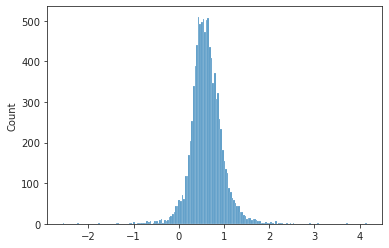

In [53]:
sns.histplot(pos_in_self[:, -1]);

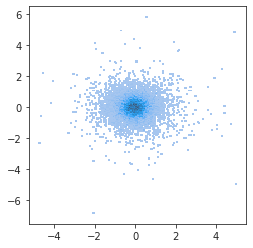

In [54]:
ax = sns.histplot(x=pos_in_self[:, 0], y=pos_in_self[:, 1])
ax_square(ax);

In [55]:
sp_stats.pearsonr(pos_in_self[:, 0], pos_in_self[:, 1])

(-0.008863892427956259, 0.375458126336278)

In [56]:
sp_stats.pearsonr(pos_in_self[:, 0], pos_in_self[:, 2])

(-0.007501385280804908, 0.4532213953210825)

In [57]:
sp_stats.pearsonr(pos_in_self[:, 1], pos_in_self[:, 2])

(-0.02036394779516435, 0.041715086256565524)

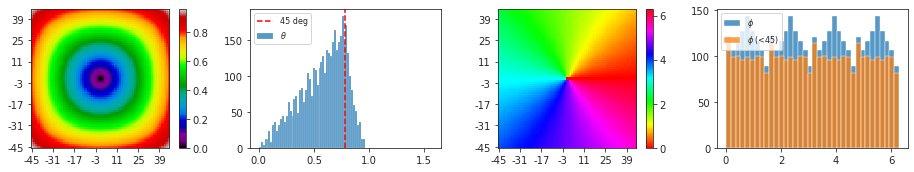

In [12]:
theta, phi = self2polar(of.alpha[..., 0], of.alpha[..., 1])
show_thetaphi(theta, phi)

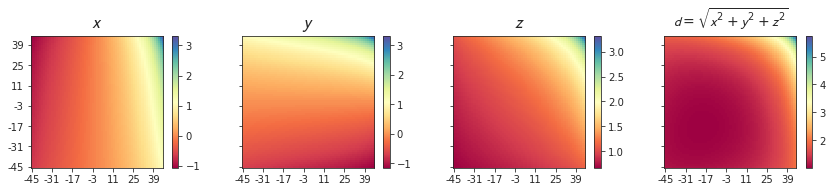

fix = [0.35320893 0.3138029  1.        ]

In [20]:
i = 154
show_xyzd(
    x=of.x[i, ..., 0],
    y=of.x[i, ..., 1],
    z=of.x[i, ..., 2],
    d=sp_lin.norm(of.x[i], axis=-1),
)
print(f"fix = {of.fix[i]}")

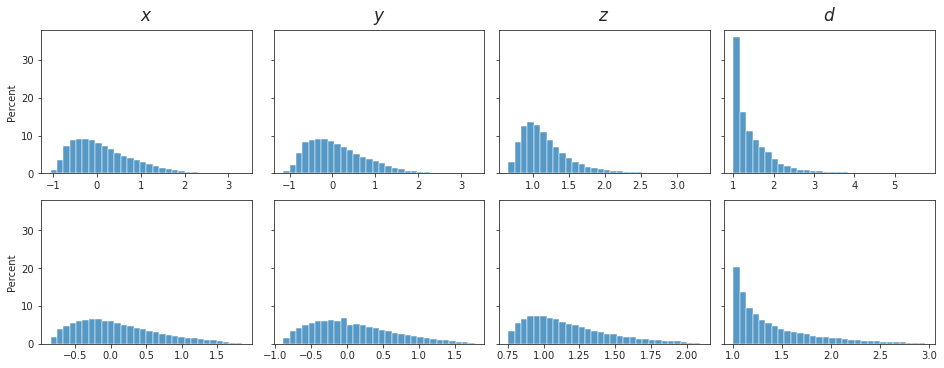

fix = [0.35320893 0.3138029  1.        ]

In [25]:
i = 154
hist_xyzd(
    x=of.x[i, ..., 0],
    y=of.x[i, ..., 1],
    z=of.x[i, ..., 2],
    d=sp_lin.norm(of.x[i], axis=-1),
)
print(f"fix = {of.fix[i]}")

In [26]:
self.x.shape

(1000, 65, 65, 3)

In [27]:
i = 152
self.x[i].shape

(65, 65, 3)

In [28]:
self.R.shape

(1000, 3, 3)

In [43]:
theta, phi = self2polar(of.alpha[..., 0], of.alpha[..., 1])

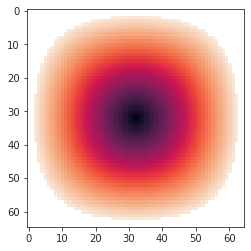

In [44]:
plt.imshow(mwh(theta >= np.deg2rad(45 * 0.95), theta))

In [82]:
ids = theta < np.deg2rad(self.fov * self.obj_lim)
tan = self.tan[ids]
ids = np.array(list(zip(*np.where(ids))))
ids.shape

(2817, 2)

In [83]:
tan.shape

(2817, 3)

In [85]:
self.obj_lim

0.9

In [277]:
ids = int(np.floor(self.obj_lim * self.dim//2))
ids = np.arange(-ids, ids + 1) + self.dim//2
ids = list(itertools.product(ids, ids))
59 ** 2, len(ids)

(3481, 3481)

In [280]:
z_lim=(0.3, 1)
kws = dict(low=z_lim[0], high=z_lim[1])

In [319]:
%%time

obj_xyz = np_nans((self.num, 3))
for i in range(self.num):
    a, b = self.rng.choice(ids)
    safety = 0
    while True:
        z = self.rng.uniform(**kws)
        xyz = self.tan[a, b] * z
        xyz = self.R[i] @ xyz
        cond = (
            xyz[-1] > 0.5 and
            xyz[-1] <= 1.0
        )
        if cond:
            break
        else:
            safety += 1
        if safety > 1000:
            xyz = np.nan
            break
    obj_xyz[i] = xyz

CPU times: user 2.35 s, sys: 72.4 ms, total: 2.43 s
Wall time: 2.41 s


In [320]:
np.isnan(obj_xyz).sum() / 3

75.0

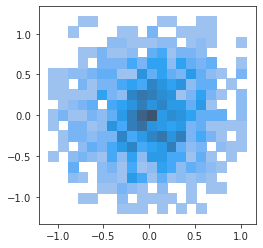

In [321]:
ax = sns.histplot(x=obj_xyz[:, 0], y=obj_xyz[:, 1])
ax_square(ax);

<AxesSubplot:ylabel='Count'>

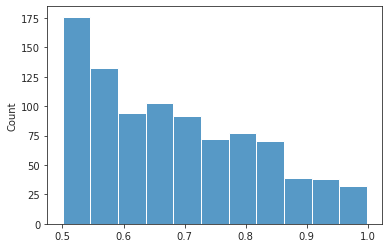

In [322]:
sns.histplot(obj_xyz[:, -1])

In [323]:
good = np.isnan(obj_xyz).sum(-1) == 0

In [324]:
sp_stats.pearsonr(self.fix[:, 0][good], obj_xyz[:, 0][good])

(0.5339215597767788, 2.7074715102718724e-69)

In [325]:
sp_stats.pearsonr(self.fix[:, 1][good], obj_xyz[:, 1][good])

(0.6129921195842902, 1.5344865685829554e-96)

In [326]:
sp_stats.pearsonr(self.fix[:, 0][good], (obj_xyz[:, 0] - self.fix[:, 0])[good])

(-0.4419818222848826, 1.6220239566508456e-45)

In [328]:
sp_stats.pearsonr(self.fix[:, 1][good], (obj_xyz[:, 1] - self.fix[:, 1])[good])

(-0.3034287635314521, 3.750045461349308e-21)

In [264]:
%%time

i = 0
obj_xyz = np_nans((self.num, 3))
while True:
    a, b = self.rng.choice(ids)
    z = self.rng.uniform(**kws)
    xyz = self.tan[a, b] * z
    xyz = self.R[i] @ xyz
    cos = 1 - sp_dist.cosine(
        self.fix[i], xyz)
    cond = (
        xyz[-1] <= 1 and
        np.rad2deg(cos) < self.fov
    )
    if cond:
        obj_xyz[i] = xyz
        i += 1
    if i == self.num:
        break

assert not np.isnan(obj_xyz).sum()

CPU times: user 8.01 s, sys: 29.5 ms, total: 8.04 s
Wall time: 7.94 s


In [267]:
i = 1
self.fix[i], obj_xyz[i]

(array([0.21327155, 0.45899312, 1.        ]),
 array([-0.41383084,  0.88607047,  0.49143926]))

<AxesSubplot:ylabel='Count'>

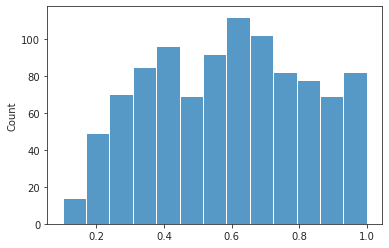

In [268]:
sns.histplot(obj_xyz[:, 2])

In [269]:
obj_fix_theta = np.rad2deg(np.arccos(1 - sp_dist.cdist(
    self.fix, obj_xyz, metric='cosine')))
obj_fix_theta.shape

(1000, 1000)

<AxesSubplot:ylabel='Count'>

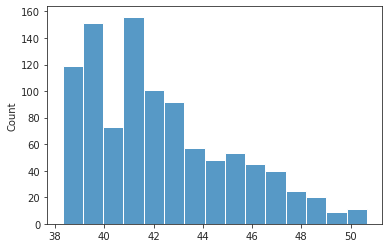

In [270]:
sns.histplot(np.diag(obj_fix_theta))

In [271]:
sp_stats.pearsonr(self.fix[:, 0], obj_xyz[:, 0])

(0.5203468063856471, 1.8069430841580596e-70)

In [272]:
sp_stats.pearsonr(self.fix[:, 1], obj_xyz[:, 1])

(0.5608771742619227, 6.221189108262927e-84)